In [3]:
%reload_ext autoreload
%autoreload 2

import seawater as sw
import oceansdb
import src.oceandepth as od
import src.iw_vmodes  as iwvm
import matplotlib.pyplot as plt

LAT = 17.5
LON = 37.5
N   = 511

#Grab Bottom Depth
dbb = oceansdb.ETOPO()
H = abs(dbb['topography'].extract(lat=LAT, lon=-LON)['height'][0])
odepth = od.odepth(H, N,lat=LAT)
z = odepth.get_dim('z')

#Grab profile from data set
db = oceansdb.WOA()
SD = db['sea_water_salinity'].extract(var='mean',depth=z,doy=136.875,lat=LAT,lon=-LON)
TD = db['sea_water_temperature'].extract(var='mean',depth=z,doy=136.875,lat=LAT,lon=-LON)


#Filter out bad data as noted by data set
tavg = np.ma.filled(TD['mean'],fill_value=-1)
tavg = tavg[tavg>=0]
savg = np.ma.filled(SD['mean'],fill_value=-1)
savg = savg[savg>=0]

#Make multi-paramter ocean depth of max depth 4000 and 1000 points
odepth.add_dim('temperature',sw.library.T90conv(tavg))
odepth.add_dim('salinity',savg)

#Generate vertical Modes
N = odepth.get_dim('bfrq')
vm = iwvm.iw_vmodes(z,N)

<IPython.core.display.Javascript object>


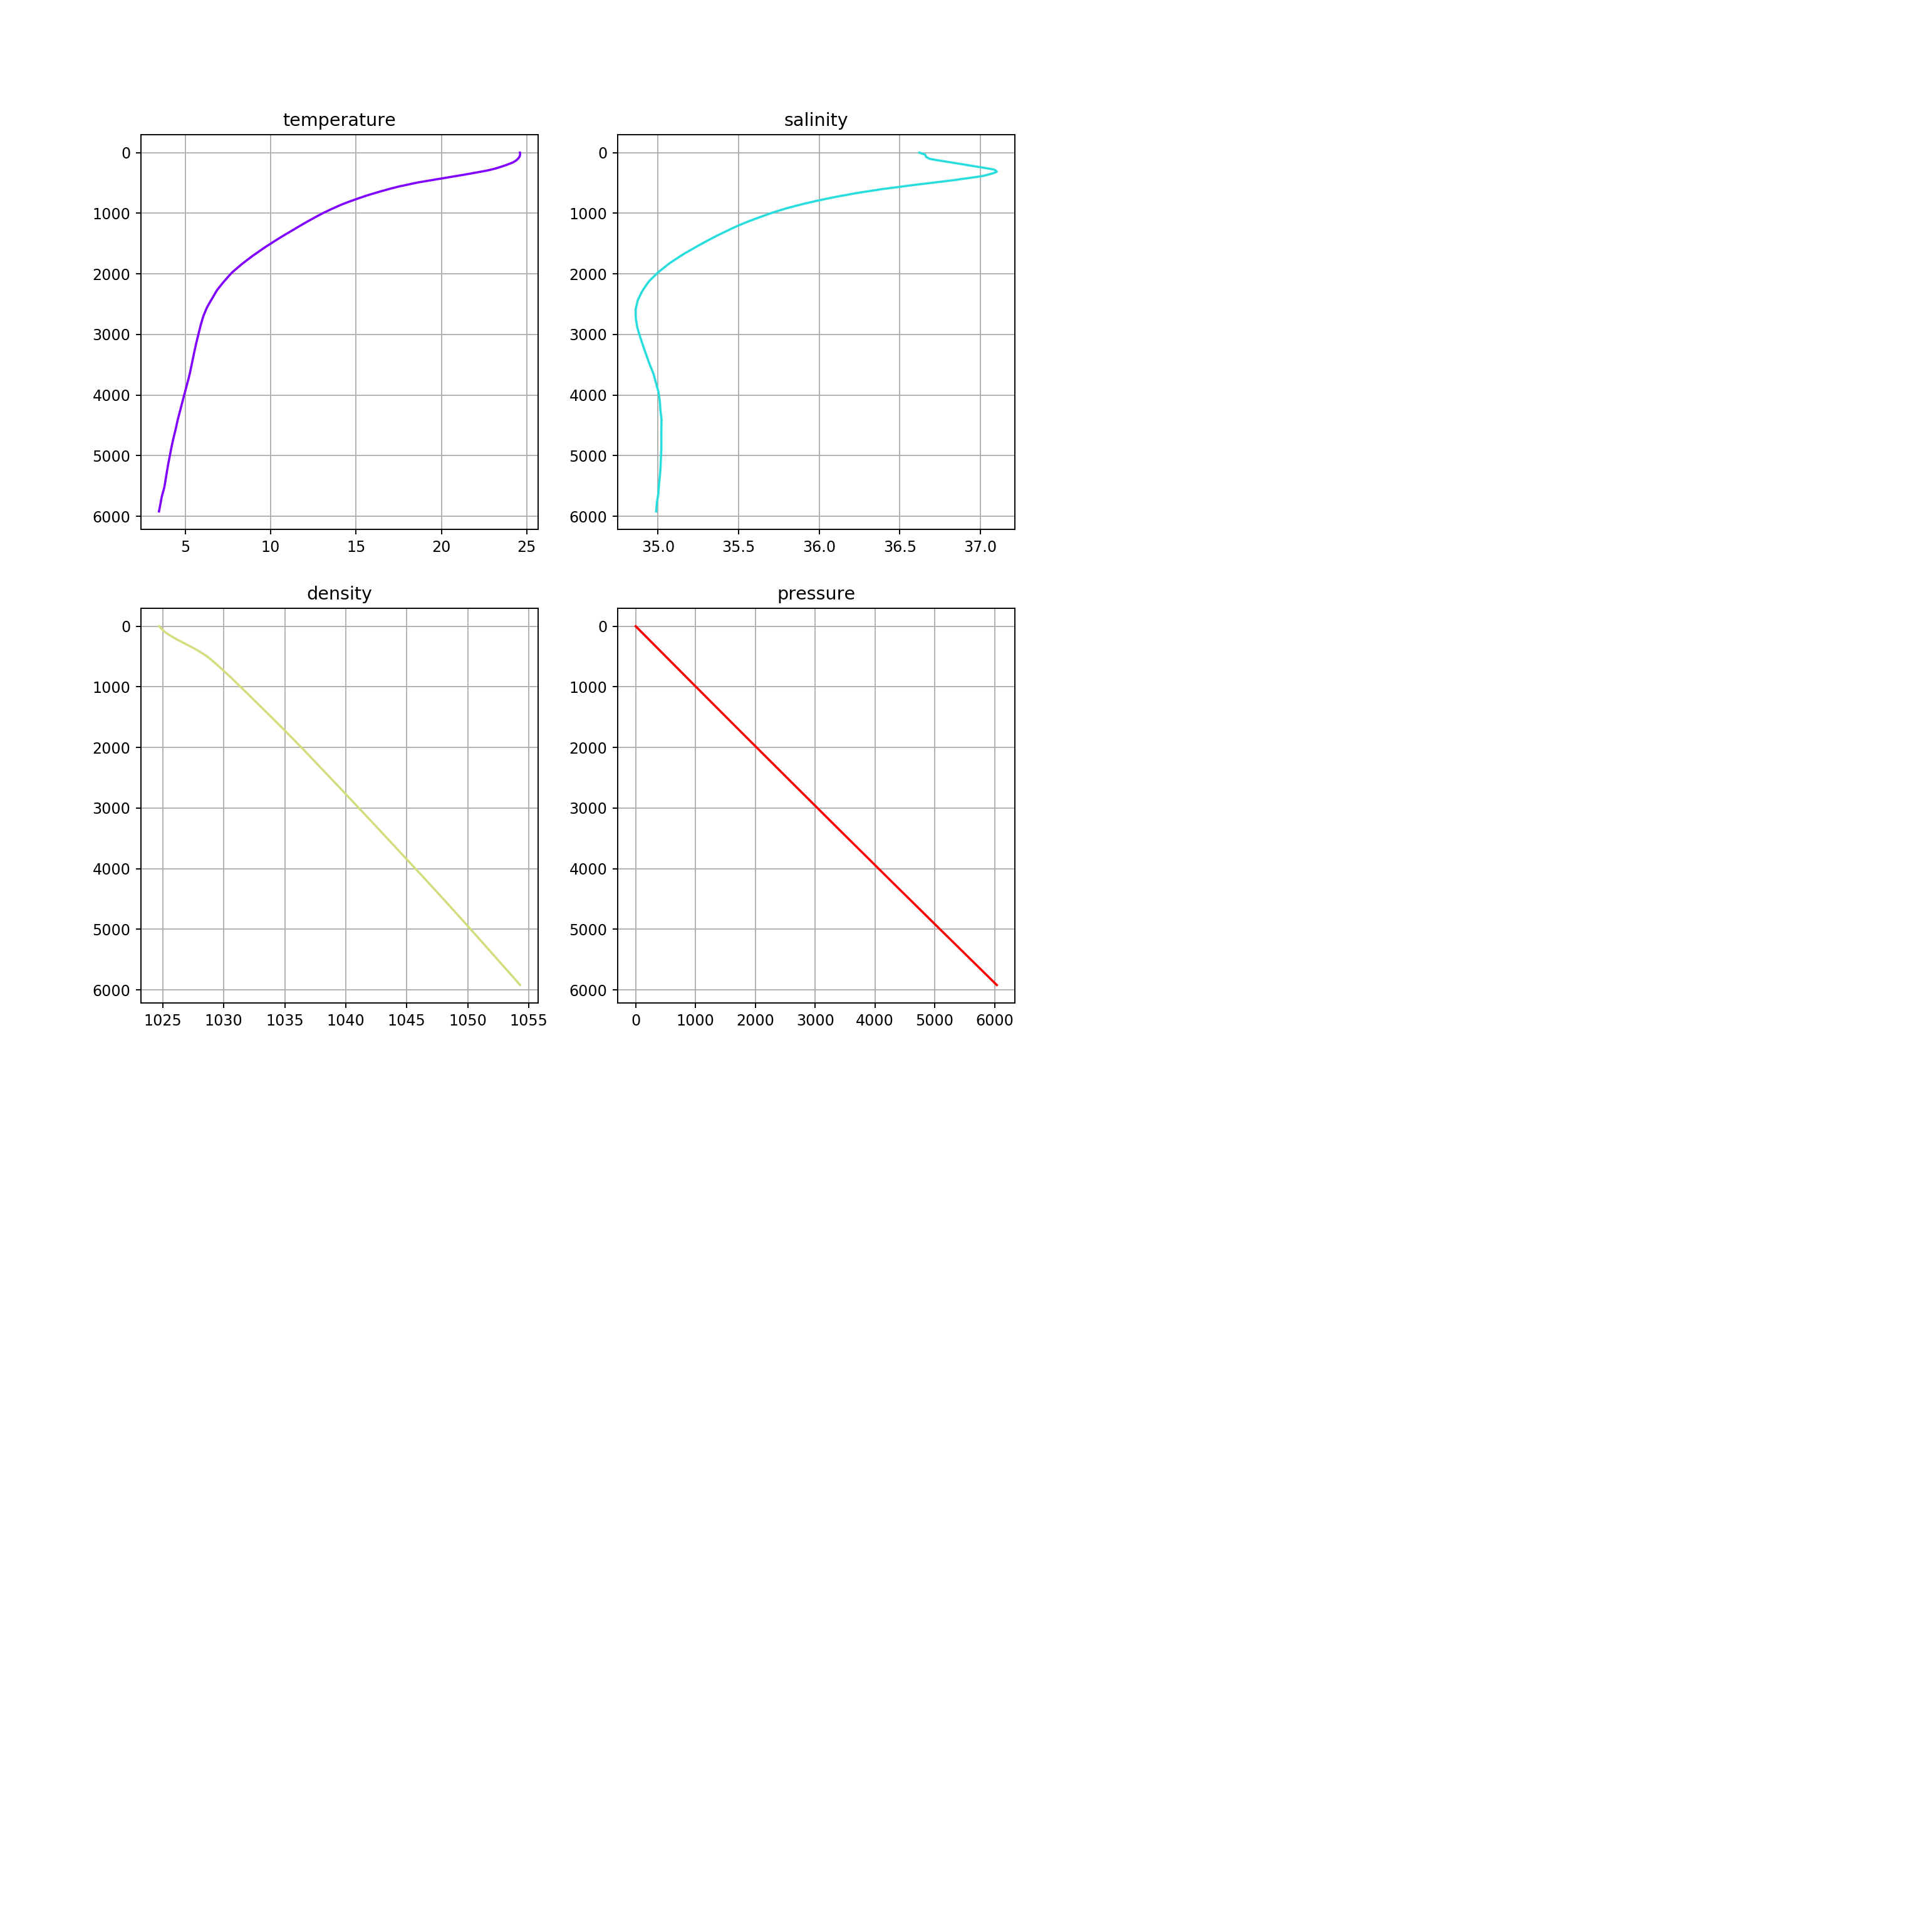

In [4]:
%matplotlib notebook
#Generate quartet of plots showing ocean depth params
f, axs = plt.subplots(2,2)
cmap = plt.cm.get_cmap('rainbow',4)
params = ['temperature','salinity','density','pressure']
for i,p in enumerate(params):
    j = 1 if i >1 else 0
    axs[j,i%2].invert_yaxis()
    ax = axs[j,i%2]
    ax.plot(odepth.get_dim(p),z,c=cmap(i))
    ax.set_title(p)
    ax.grid()

f.set_size_inches(10.5, 10.5)
f.savefig('../figs/ocean_depth_profile.png')

<IPython.core.display.Javascript object>


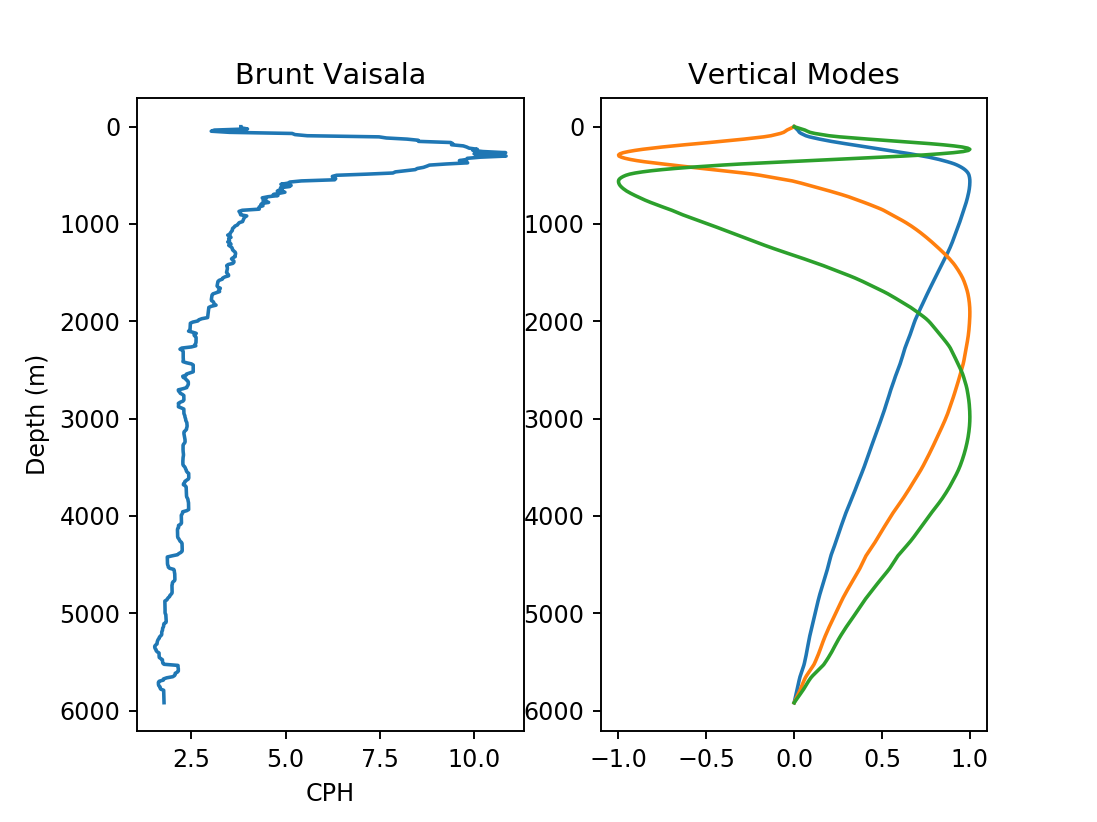

In [5]:
from scipy.integrate import solve_bvp, quad, trapz
f, (ax1,ax2) = plt.subplots(1,2)

pres = odepth.get_dim('pressure')
d2   = sw.eos80.dpth(pres,LAT)

#Plot N
ax1.invert_yaxis()
ax1.set_title('Brunt Vaisala')
ax1.plot(np.sqrt(odepth.get_dim('bfrq')/ (2*np.pi)) *(60**2),d2)
ax1.set_xlabel("CPH")
ax1.set_ylabel("Depth (m)")

#Plot vertical modes
ax2.invert_yaxis()
ax2.set_title('Vertical Modes')
for i in range(1,4):
    ax2.plot(vm.gen_vmodes_wkb(i),d2)

f.savefig('../figs/iw_vmodes_realistic.png')

Using the numerical formula from colosi to calcuate the 2D displacement field.


$$\zeta(x,z) = Re \Big[ \frac{2B}{\pi} \frac{E}{M}^{\frac{1}{2}} \frac{N_o}{N(z)}^{\frac{1}{2}}  \sum_j \frac{sin(j \pi \zeta(z))}{\sqrt{j^2 + j*^2}} \sum_{k_x} \sqrt{I(j,k_x)} e^{i \phi(k_x,j)} e^{i k_x} \Big] $$ 

In [18]:
def kj(j):
    return np.pi * j

#Defines power spectrum of the waves
def I(j,k_x):
    k_j = kj(j)
    mag = np.sqrt(k_j**2 + k_x**2)
    log = np.log ( (mag + k_j)/(mag -k_j) )
    ret = k_j/mag**2 + 0.5*( k_x**2/mag**3 )*log
    return ret

#Defines the horizontal part of the wave field in k-space
def range_kspace(j,k_x):
    rp = np.random.uniform(0,2*np.pi,(511,))
    return np.multiply(np.sqrt(I(j,k_x)),np.exp(1j*rp))

#Defines the horizontal part of the wave field in the spacial domain
def range_comp(j):
    #TODO put k space parameter somewhere else
    #k_xv = 2*np.pi*np.arange(1,512)/10000
    k_xv = 2*np.pi*np.arange(1,512)
    return np.fft.ifft(range_kspace(j,k_xv))

#Defines the vertical part of the wavefield in the spacial domain
def vert_comp(j):
    jstar = 3 
    return vm.gen_vmodes_wkb(j) /np.sqrt((j**2 + jstar**2))


#Defines wavefield in spacial domain using components above
def displacement_field(nmodes=10):
    hcv = [range_comp(j).real for j in range(1,nmodes)]
    vcv = [vert_comp(j) for j in range(1,nmodes)]
    
    df = []
    for i in range(0,len(vcv[0])):
        dfr = np.zeros(len(hcv[0]))
        for j in range(0,nmodes-1):
            dfr += vcv[j][i]*hcv[j]
        df.append(dfr)
    return np.vstack(df)



<IPython.core.display.Javascript object>


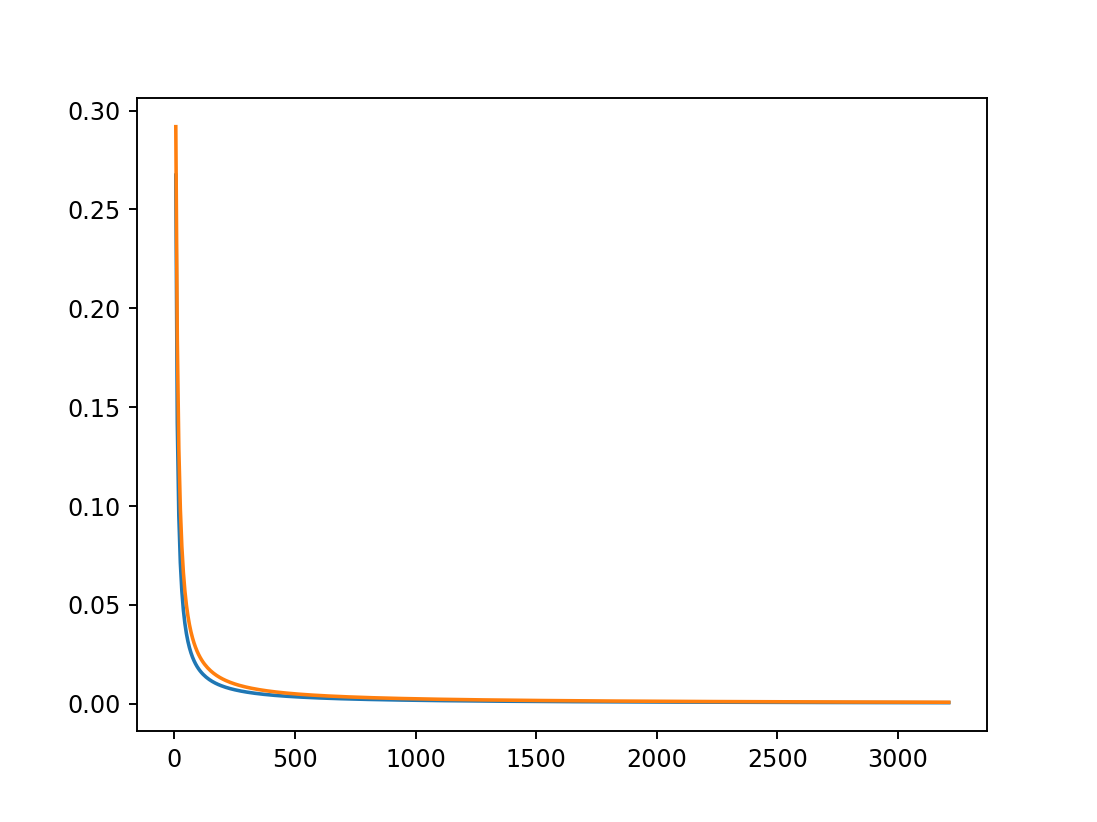

In [14]:
%matplotlib notebook
kx = 2*np.pi*np.arange(1,512)
plt.plot(kx,np.sqrt(I(1,kx)))
plt.plot(kx,np.sqrt(I(2,kx)))

<IPython.core.display.Javascript object>


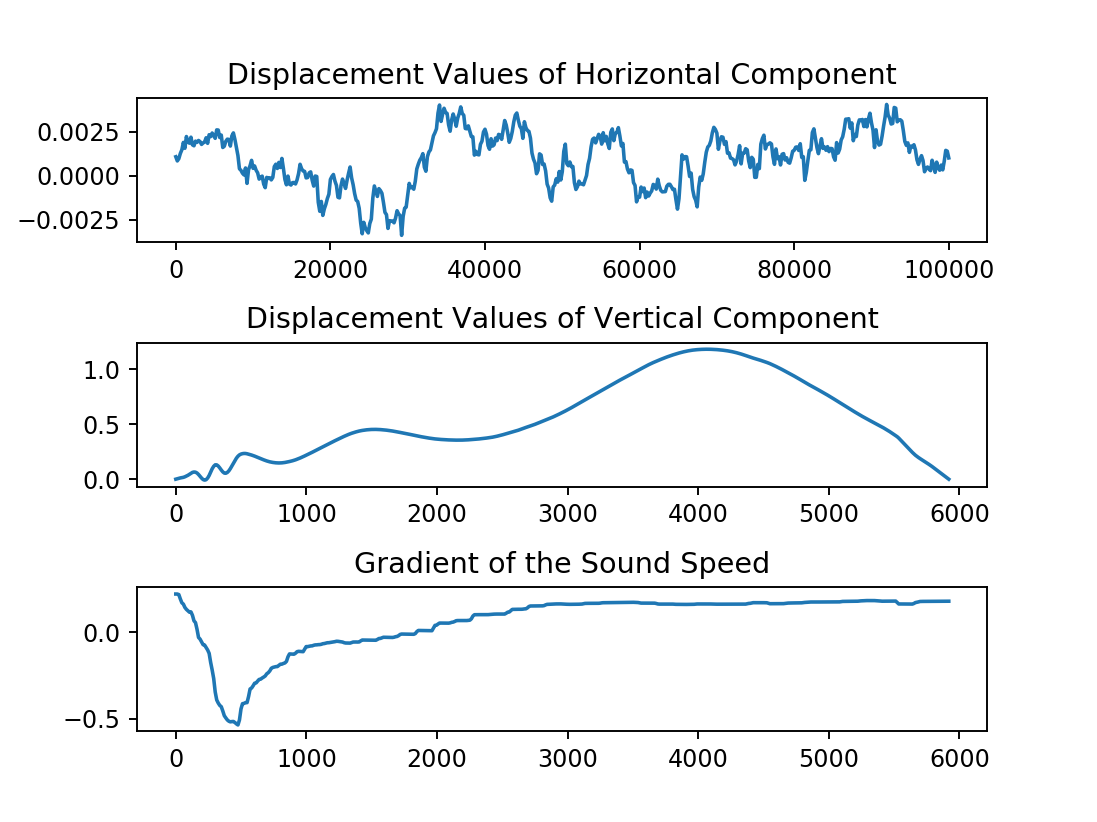

Text(0.5, 1.0, 'Gradient of the Sound Speed')

In [15]:
%matplotlib notebook
t = np.linspace(0,100000,511)

f ,(ax1,ax2,ax3) = plt.subplots(3)
plt.subplots_adjust(hspace=0.7)
dc = np.gradient(odepth.get_dim('svel'))
rc = vc = 0
for i in range(1,10):
    rc += range_comp(i)
    vc += vert_comp(i)
    
ax1.plot(t,rc)
ax1.set_title("Displacement Values of Horizontal Component")
ax2.plot(d2,vc) 
ax2.set_title("Displacement Values of Vertical Component")
ax3.plot(d2,dc)
ax3.set_title("Gradient of the Sound Speed")

<IPython.core.display.Javascript object>


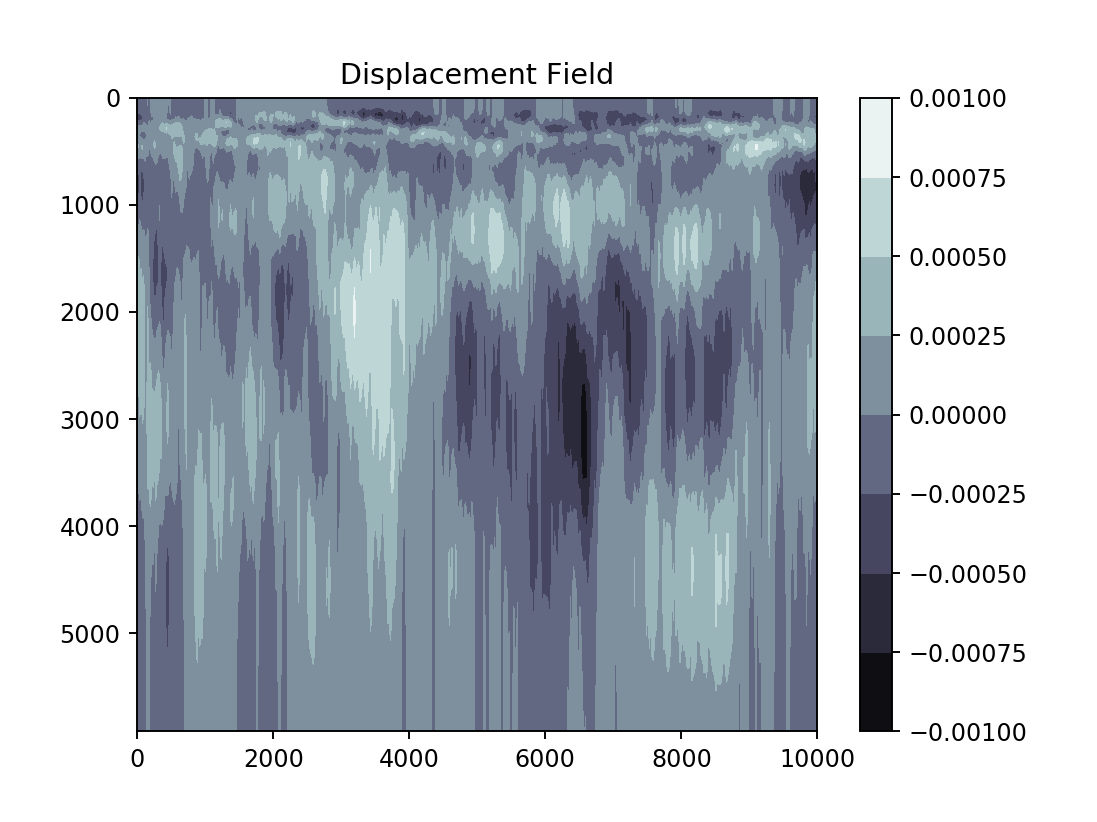

In [16]:
%matplotlib notebook
x  = np.linspace(0,10000,511) 
df =  displacement_field(11)
xx,zz = np.meshgrid(x,d2)

f , ax = plt.subplots(1)
plt.gca().invert_yaxis()
p = ax.contourf(xx,zz,df,cmap='bone')
ax.set_title('Displacement Field')
f.colorbar(p)
plt.savefig('../figs/iwf_wkb.png',dpi=200)

### Compute the horizontal auto-covariance 
$$ r(\tau) = <y(t)y^*(t-\tau)> $$


<IPython.core.display.Javascript object>


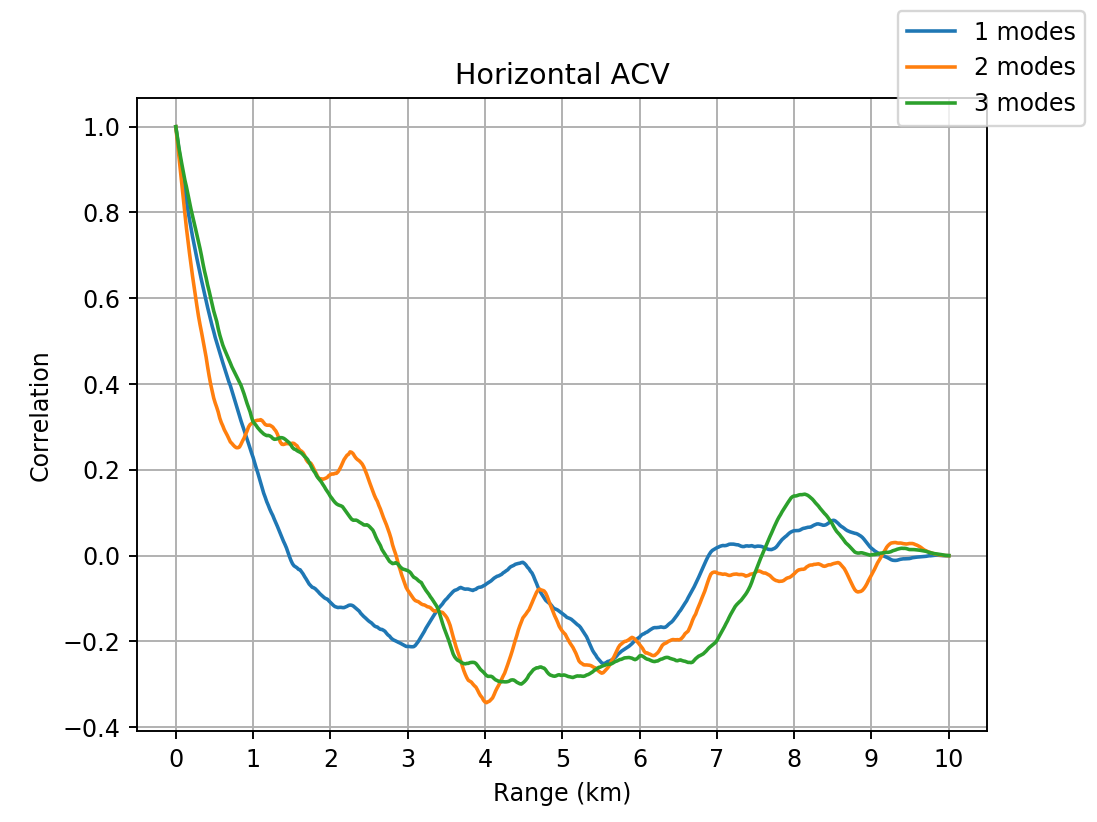

In [17]:
import random
import scipy.signal as signal
import src.tools.plotbox as plotbox
%matplotlib notebook

def autocovariance(x,tau):
    if tau < 0 or tau > len(x):
        print("Out of bounds : tau")
        return
    else:
        lim  = abs(round(len(x)-tau))
        xavg = np.average(x) 
        ac = 0
        for t in range(lim):
            ac += np.conjugate(x[t+tau] - xavg)*(x[t]-xavg)
        return ac/(len(x)-1.0)

def autocorrelation(x,tau):
    return autocovariance(x,tau) / autocovariance(x,0)

#Generate more realizations with different sets of modes 
set_of_df = [displacement_field(i) for i in np.arange(2,5)]

#Grab a random row 
n = random.randint(0,df.shape[0])

#Plot the autocovariance of the displacement field for n modes 
#n ranging from 1 to 4
f,ax1 = plt.subplots(1)
for i,dfs in enumerate(set_of_df):
    hv = dfs[n,:]
    acsh = [autocorrelation(hv,n) for n in range(0,len(hv))]
    ax1.plot(np.linspace(0,10,511),acsh,label= "%d modes" % (i+1))


plotbox.setattributes(ax1,"Range (km)","Correlation",
                      "Horizontal ACV",True,np.arange(0,11,1))

f.legend()

<IPython.core.display.Javascript object>


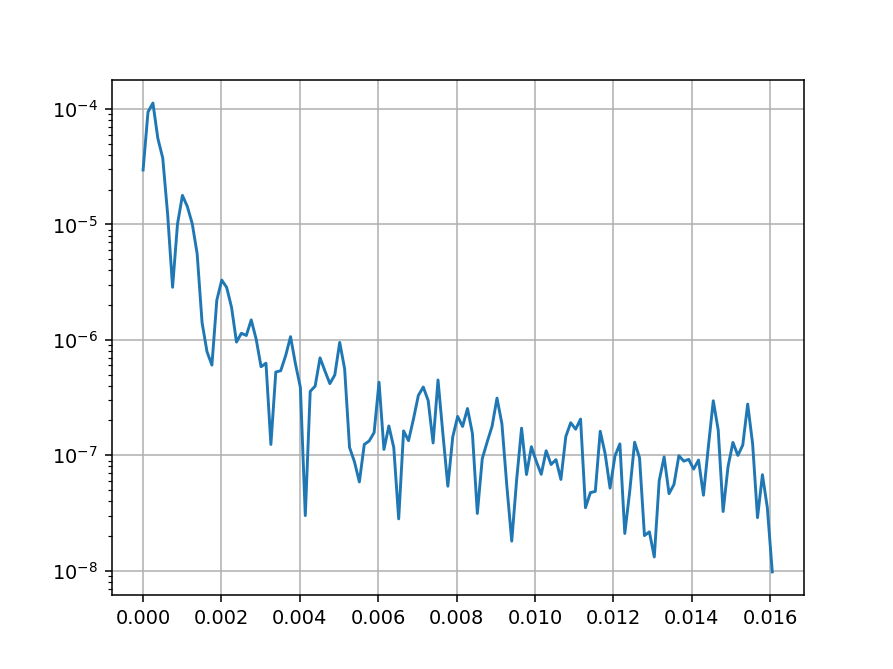

In [108]:
#Power Spectral Density Plot 
def psdplot(s,fs,ax):
    f,Pxx = signal.welch(s,fs)
    ax.semilogy(f,Pxx)
    
fig,ax1 = plt.subplots(1)
psdplot(hv,2*np.pi*len(hv)/1e5,ax1)
plotbox.setattributes(ax1,grid=True)